In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix, roc_curve

In [2]:
data_location = 'data/dataset_turnos.csv'
data = pd.read_csv(data_location)
data.drop(["Unnamed: 0"],axis=1,inplace=True)
data.head()

,appointmentfromtime,DayName,priordayholiday,nextdayholiday,day,hour,outofschedule,appointmentstate,age,daysbeforereserved,...,precipcover,windgust,windspeed,sealevelpressure,visibility,solarradiation,uvindex,conditions,llovio,month
0,4/1/2021 08:49,Monday,0,0,4,8,0,0,1,0,...,0.0,0.0,24.9,1013.0,7.4,147.3,5,Overcast,0,1
1,4/1/2021 09:20,Monday,0,0,4,9,0,1,2,0,...,0.0,0.0,24.9,1013.0,7.4,147.3,5,Overcast,0,1
2,4/1/2021 09:40,Monday,0,0,4,9,0,0,1,19,...,0.0,0.0,24.9,1013.0,7.4,147.3,5,Overcast,0,1
3,4/1/2021 10:20,Monday,0,0,4,10,0,1,8,19,...,0.0,0.0,24.9,1013.0,7.4,147.3,5,Overcast,0,1
4,4/1/2021 10:20,Monday,0,0,4,10,0,1,16,12,...,0.0,0.0,24.9,1013.0,7.4,147.3,5,Overcast,0,1


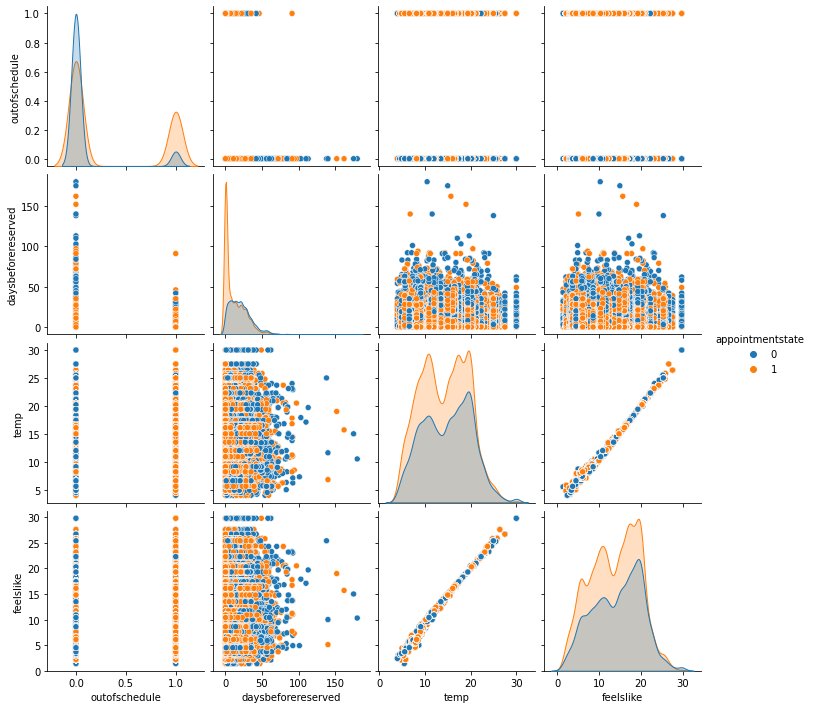

In [3]:
sns.pairplot(data, vars=['outofschedule','daysbeforereserved','temp','feelslike'],hue="appointmentstate")

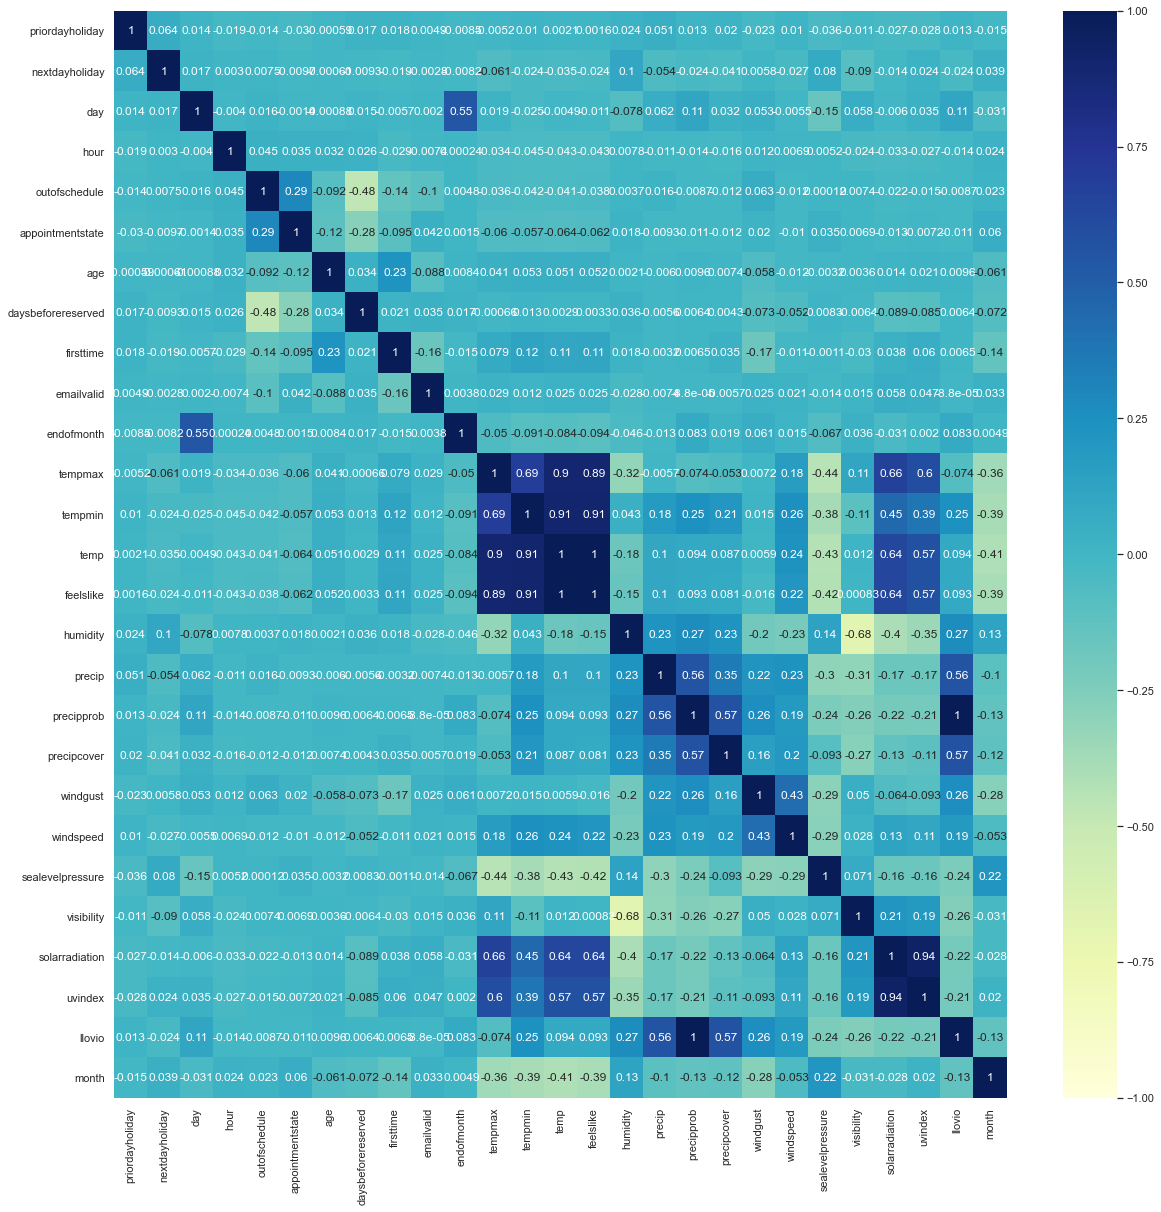

In [5]:
# Matriz de correlación
sns.set(rc = {'figure.figsize':(20,20)})
sns.heatmap(data.corr(), vmin=-1, vmax=1, center=0, annot=True, cmap="YlGnBu");

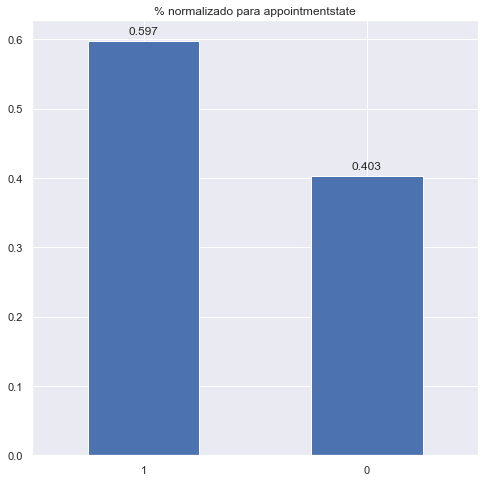

In [6]:
plt.rcParams["figure.figsize"] = (8,8)
#plt.rcParams['figure.dpi'] = 200
ax=data['appointmentstate'].value_counts(normalize=True).plot(kind='bar')
plt.xticks(rotation=0, horizontalalignment="center");
plt.title("% normalizado para appointmentstate");
for p in ax.patches:
    ax.annotate(text=np.round(p.get_height(), decimals=3),
                xy=(p.get_x()+p.get_width()/2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points')
plt.show()

---
### Preparación de datos

In [7]:
#Dummies
columns_dummies=['DayName', 'gender', 'healthcoverage','conditions']
data_dummies = pd.get_dummies(data[columns_dummies],drop_first=True)

In [8]:
#Columnas no Dummies
columns_nodummies = data.drop(columns_dummies,axis=1).columns
columns_nodummies = columns_nodummies.drop(['appointmentfromtime','day','appointmentstate'])

In [9]:
#Concateno columnas y preparo mis features y mi target
X = pd.concat([data[columns_nodummies],data_dummies], axis=1)
Y = data['appointmentstate']
#Y = (data['appointmentstate']*-1) + 1

---
### Entrenamiento del modelo

In [10]:
# Obtengo mis train/test
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=10,test_size = 0.20, stratify=Y)

# Normalizo 
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

---
### Modelos

In [11]:
# Folds Stratified para mantener la relación
folds=StratifiedKFold(n_splits=5, random_state=19, shuffle=True)

#### KNN

In [12]:
knn = KNeighborsClassifier()
leaf_size = list(range(1,50))
n_neighbors = list(range(3,50))
p=[1,2]
weights = ['uniform', 'distance']

param_grid_knn = dict(n_neighbors=n_neighbors, leaf_size=leaf_size, p=p, weights=weights)

In [13]:
#grid_knn=GridSearchCV(knn,param_grid_knn,scoring='roc_auc',n_jobs=4)
#grid_knn.fit(X_train_normalized,y_train)

#### Regresión Logística

In [14]:
logit_normalized = LogisticRegression()
logit=LogisticRegression()

C=np.logspace(-3,3,7)
penalty = ['l1', 'l2', 'elasticnet']
max_iter = [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300]
solver = ['newton-cg','lbfgs','liblinear', 'sag', 'saga']

param_grid_logistic_normalized = dict(C=C,penalty=penalty,max_iter=max_iter,solver=solver)
param_grid_logistic = dict(C=C,penalty=['none'],solver=solver,max_iter=max_iter)

#### Naive Bayes

In [15]:
gaussian = GaussianNB()
var_smoothing=np.logspace(0,-9, num=100)
gaussiannb_params = dict(var_smoothing=var_smoothing)

In [16]:
models_1 = [logit_normalized, gaussian]
models_2 = [knn, logit_normalized, gaussian]
params_1 = [param_grid_logistic_normalized, gaussiannb_params]
params_2 = [param_grid_knn, param_grid_logistic_normalized, gaussiannb_params]

-------
Utilizar alguno de los dos bloques de código siguientes según la computadora, para ello convertir el bloque de markdown a código o al revés. El primero utiliza un random gridsearch para KNN y un gridsearch convencional para los otros modelos. El segundo bloque utiliza solo gridsearch y hace que KNN demore bastante tiempo en encontrar los mejores hiperparámetros

---------

In [17]:
'''Método 1 con random gridsearch para KNN y gridsearch para el resto'''
grids = []

gs = RandomizedSearchCV(knn, param_grid_knn, n_iter=50, cv=folds, scoring='roc_auc',random_state=10, n_jobs=-1, verbose=2)
fit = gs.fit(X_train_normalized, y_train)
grids.append(fit)

for i in range (len(models_1)):
    gs = GridSearchCV(estimator=models_1[i], param_grid=params_1[i], scoring='roc_auc', cv=folds, n_jobs=-1, verbose=2)
    fit = gs.fit(X_train_normalized,y_train)
    grids.append(fit)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.1min finished


Fitting 5 folds for each of 1365 candidates, totalling 6825 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 696 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 1658 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 2485 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 3125 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 3642 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4265 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4956 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 5789 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 6720 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 6802 out of 6825 | elapsed:  6.5min remaining:    1.2s
[Parallel(n_jobs=-1)]: Done 6825 out of 6825 | elapsed:  6.5min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished


--------

'''Metodo 2 con gridsearch para todo'''
grids = []
for i in range (len(models_2)):
    gs = GridSearchCV(estimator=models_2[i], param_grid=params_2[i], scoring='roc_auc', cv=folds, n_jobs=-1, verbose=2)
    fit = gs.fit(X_train_normalized,y_train)
    grids.append(fit)

-------
A partir de acá ya no hace falta seleccionar el tipo de gridsearch

In [18]:
# Obtenemos el gridsearch para logistic sin normalizar
gs = GridSearchCV(estimator=logit, param_grid=param_grid_logistic, scoring='roc_auc', cv=folds, n_jobs=-1, verbose=2)
fit = gs.fit(X_train,y_train)
grids.append(fit)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 455 candidates, totalling 2275 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 365 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1013 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 1458 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 1985 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 2275 out of 2275 | elapsed: 16.6min finished
C:\Users\nacho\miniconda3\envs\dsdh22\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\nacho\miniconda3\envs\dsdh22\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


-----

In [19]:
#Definición de funciones para métricas y gráficos a usar recurrentemente en las secciones siguientes
def getmetrics(conf_mat):
    return conf_mat[1,1],conf_mat[0,0],conf_mat[0,1],conf_mat[1,0]

def printscores(test,predict):
    TP,TN,FP,FN = getmetrics(confusion_matrix(test, predict))
    return pd.DataFrame(
                {'': [accuracy_score(test, predict),
                            recall_score(test, predict),
                            precision_score(test, predict),
                            f1_score(test, predict),
                            TN / (TN + FP)
                           ]},
                index=['Accuracy','Recall', 'Precision', 'F1 Score', 'Specificity']
            )

def heatmap_matrix_data(y_test,y_preds, title):
    cf_matrix = confusion_matrix(y_test, y_preds)
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="BuGn",cbar=False, ax=ax)
    plt.title(title)
    plt.xlabel('Predicted \n'+printscores(y_test,y_preds).to_string())
    plt.ylabel('True')
    plt.show()

----
### Análisis primario

Cálculos de valores predichos y probabilidades

In [20]:
# Calculamos valores predichos para KNN, Logistic y NB con los valores normalizados
y_preds = []
for i in range(len(grids)-1):
    y_preds.append(grids[i].predict(X_test_normalized))
    
# Calculamos valores predichos para Logistic sin normalizar
y_preds.append(grids[len(grids)-1].predict(X_test))

In [21]:
# Valores de probabilidad para cada predicción
y_preds_proba = []

for i in range(len(grids)-1):
    y_preds_proba.append(grids[i].predict_proba(X_test_normalized))
    
y_preds_proba.append(grids[len(grids)-1].predict_proba(X_test))

#### Parámetros

In [22]:
print("Mejores parámetros para KNN:",grids[0].best_params_)
print("Roc_auc score obtenido:",grids[0].best_score_)
print("")
print("Mejores parámetros para Logística con penalidad:",grids[1].best_params_)
print("Roc_auc score obtenido:",grids[1].best_score_)
print("")
print("Mejores parámetros para Naive Bayes:",grids[2].best_params_)
print("Roc_auc score obtenido:",grids[2].best_score_)
print("")
print("Mejores parámetros para Logística sin penalidad:",grids[3].best_params_)
print("Roc_auc score obtenido:",grids[3].best_score_)

Mejores parámetros para KNN: {'weights': 'distance', 'p': 2, 'n_neighbors': 49, 'leaf_size': 13}
Roc_auc score obtenido: 0.7002028351721871

Mejores parámetros para Logística con penalidad: {'C': 0.001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Roc_auc score obtenido: 0.7119621824780932

Mejores parámetros para Naive Bayes: {'var_smoothing': 1.0}
Roc_auc score obtenido: 0.6967300800328381

Mejores parámetros para Logística sin penalidad: {'C': 10.0, 'max_iter': 900, 'penalty': 'none', 'solver': 'sag'}
Roc_auc score obtenido: 0.71233996927721


#### Análisis para KNN

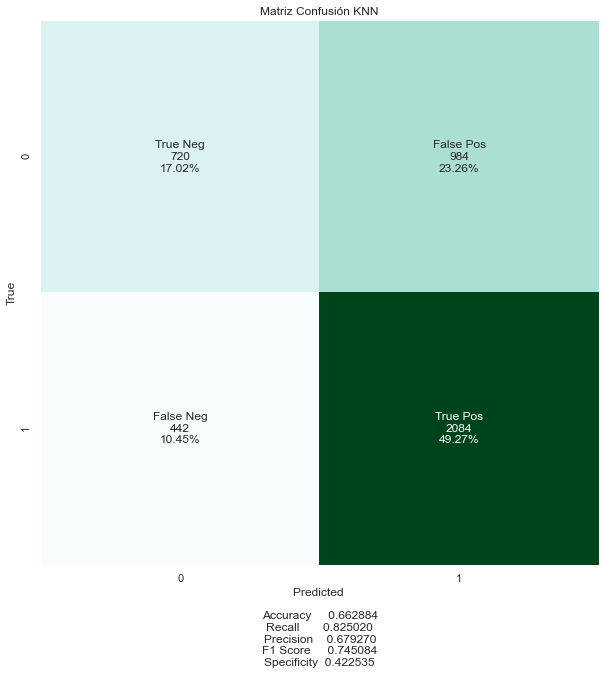

In [23]:
heatmap_matrix_data(y_test, y_preds[0], 'Matriz Confusión KNN');

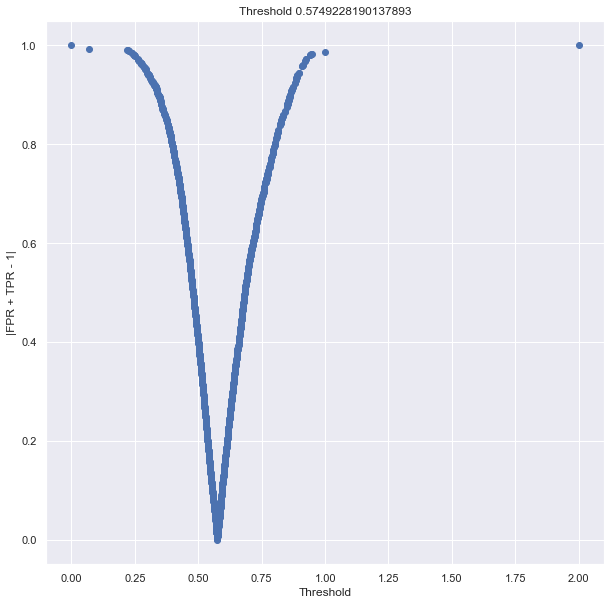

In [24]:
fpr_knn,tpr_knn,thr_knn = roc_curve(y_test, y_preds_proba[0][:,1])
best_threshold_knn = thr_knn[np.argmin(np.abs(fpr_knn+tpr_knn-1))]

fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(thr_knn,np.abs(fpr_knn+tpr_knn-1))
plt.xlabel("Threshold")
plt.ylabel("|FPR + TPR - 1|")
plt.title("Threshold "+str(best_threshold_knn))
plt.show()

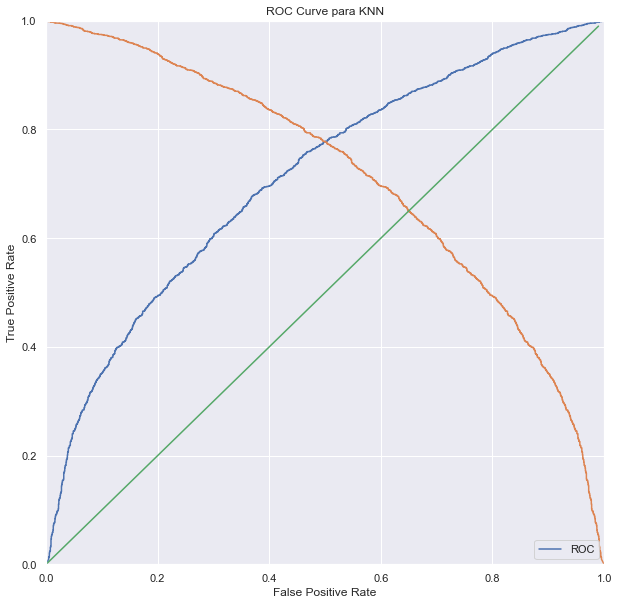

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve para KNN')
plt.plot(fpr_knn, tpr_knn, label="ROC")
plt.plot(1-fpr_knn,tpr_knn)
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.legend()
plt.show()

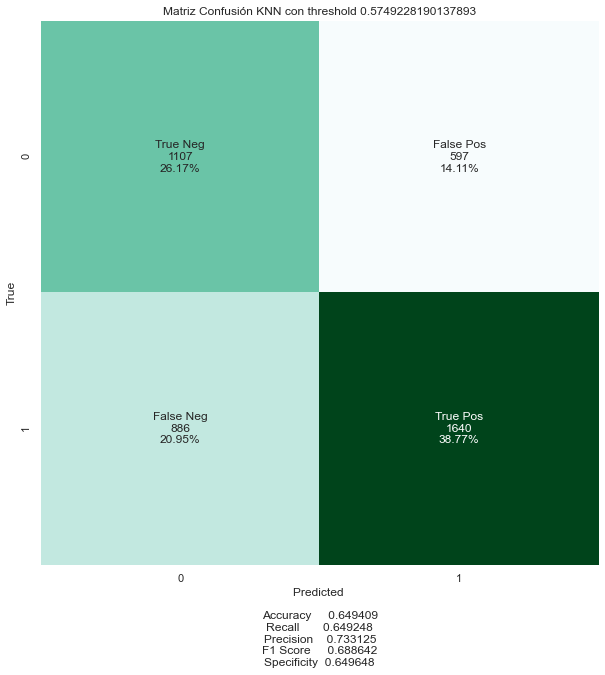

In [26]:
y_pred_knn_umbral = (y_preds_proba[0][:,1] > best_threshold_knn).astype(int)
heatmap_matrix_data(y_test, y_pred_knn_umbral, 'Matriz Confusión KNN con threshold '+str(best_threshold_knn));

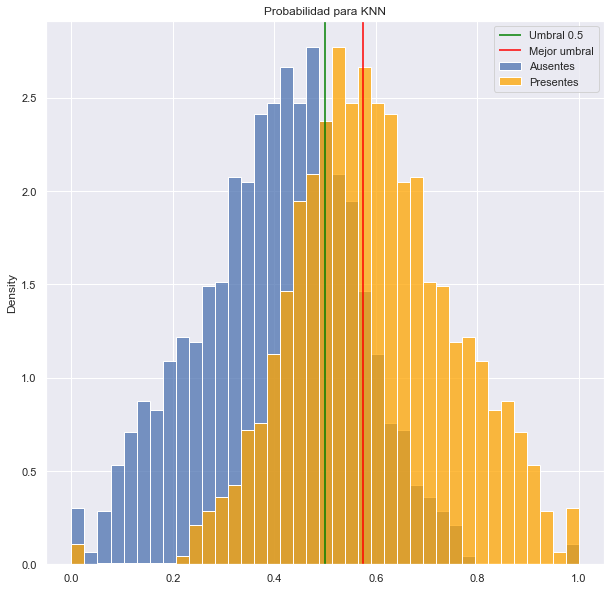

In [27]:
fig, ax = plt.subplots(figsize=(10,10))
sns.histplot(data = y_preds_proba[0][:,0], stat = 'density', ax=ax, label="Ausentes")
sns.histplot(data = y_preds_proba[0][:,1], stat = 'density', color = 'orange', ax=ax, label="Presentes")
ylim = plt.ylim()
plt.vlines(0.5, ylim[0], ylim[1], color="green", label="Umbral 0.5")
plt.vlines(best_threshold_knn, ylim[0], ylim[1], color="red", label="Mejor umbral")
plt.ylim(ylim)
plt.title('Probabilidad para KNN')
plt.legend()
plt.show()

#### Análisis para Logístico con normalización

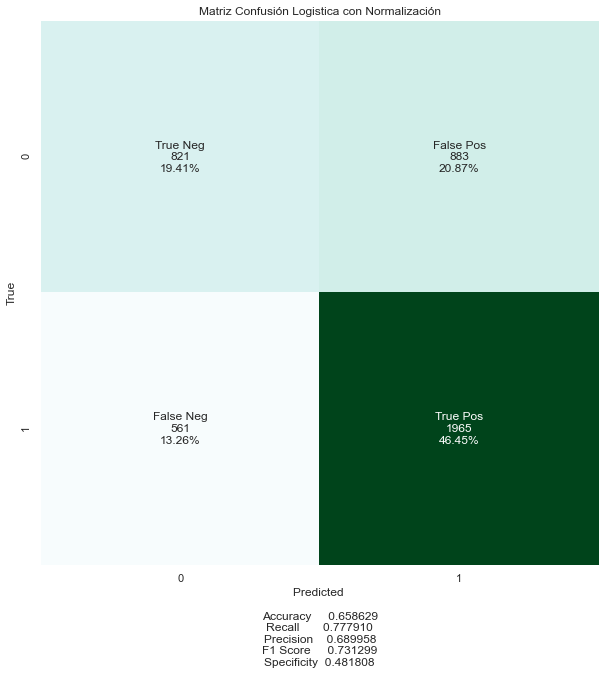

In [28]:
heatmap_matrix_data(y_test, y_preds[1], 'Matriz Confusión Logistica con Normalización');

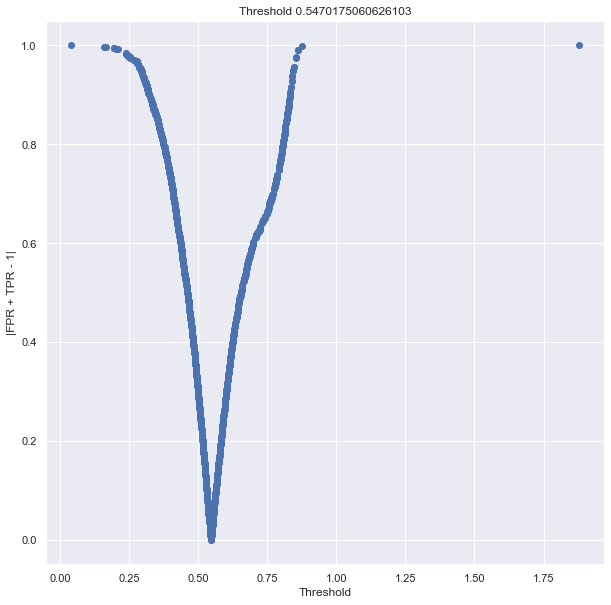

In [29]:
fpr_logit1,tpr_logit1,thr_logit1 = roc_curve(y_test, y_preds_proba[1][:,1])
best_threshold_logit1 = thr_logit1[np.argmin(np.abs(fpr_logit1+tpr_logit1-1))]

fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(thr_logit1,np.abs(fpr_logit1+tpr_logit1-1))
plt.xlabel("Threshold")
plt.ylabel("|FPR + TPR - 1|")
plt.title("Threshold "+str(best_threshold_logit1))
plt.show()

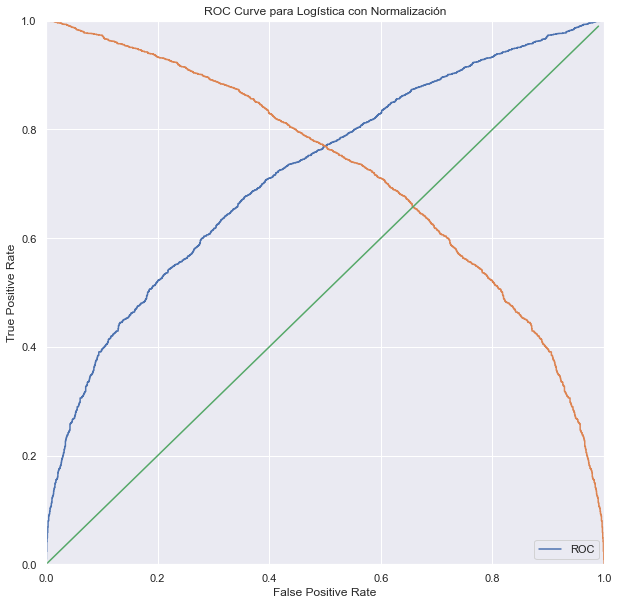

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve para Logística con Normalización')
plt.plot(fpr_logit1, tpr_logit1, label="ROC")
plt.plot(1-fpr_logit1,tpr_logit1)
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.legend()
plt.show()

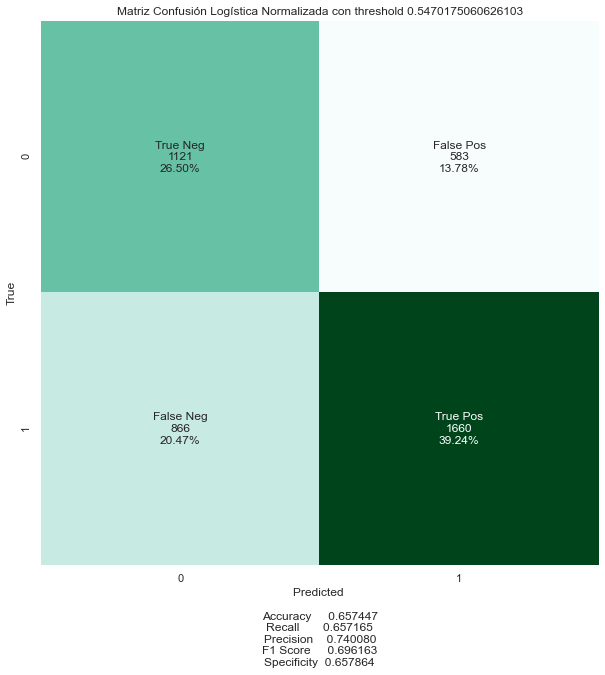

In [31]:
y_pred_logit1_umbral = (y_preds_proba[1][:,1] > best_threshold_logit1).astype(int)
heatmap_matrix_data(y_test, y_pred_logit1_umbral, 'Matriz Confusión Logística Normalizada con threshold '+str(best_threshold_logit1));

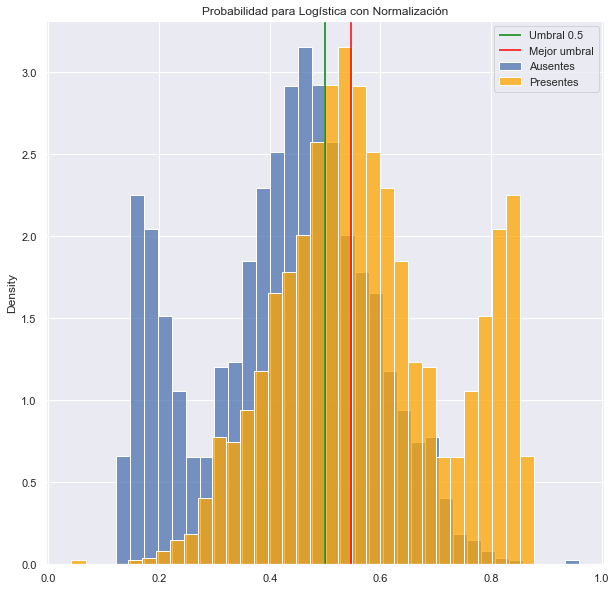

In [32]:
fig, ax = plt.subplots(figsize=(10,10))
sns.histplot(data = y_preds_proba[1][:,0], stat = 'density', ax=ax, label="Ausentes")
sns.histplot(data = y_preds_proba[1][:,1], stat = 'density', color = 'orange', ax=ax, label="Presentes")
ylim = plt.ylim()
plt.vlines(0.5, ylim[0], ylim[1], color="green", label="Umbral 0.5")
plt.vlines(best_threshold_logit1, ylim[0], ylim[1], color="red", label="Mejor umbral")
plt.ylim(ylim)
plt.title('Probabilidad para Logística con Normalización')
plt.legend()
plt.show()

#### Análisis para Naive Bayes

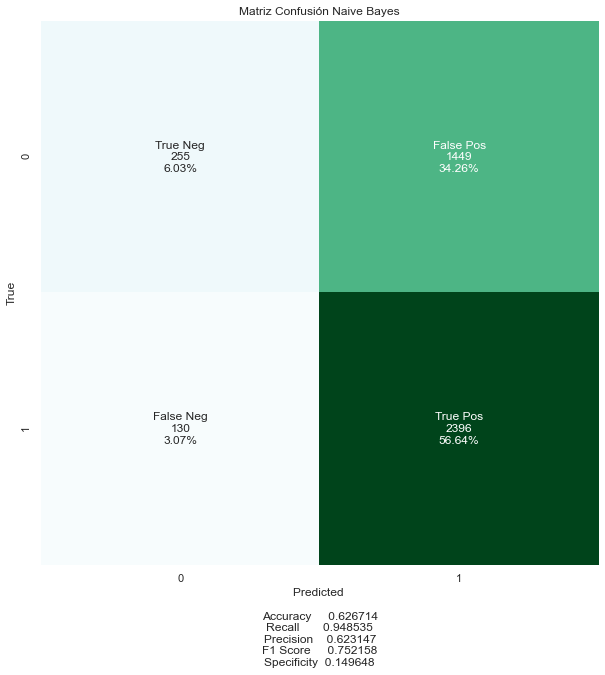

In [33]:
heatmap_matrix_data(y_test, y_preds[2], 'Matriz Confusión Naive Bayes');

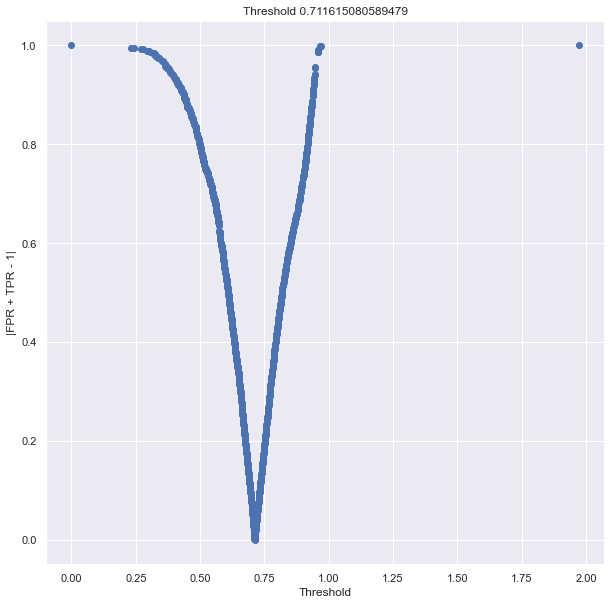

In [34]:
fpr_nb,tpr_nb,thr_nb = roc_curve(y_test, y_preds_proba[2][:,1])
best_threshold_nb = thr_nb[np.argmin(np.abs(fpr_nb+tpr_nb-1))]

fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(thr_nb,np.abs(fpr_nb+tpr_nb-1))
plt.xlabel("Threshold")
plt.ylabel("|FPR + TPR - 1|")
plt.title("Threshold "+str(best_threshold_nb))
plt.show()

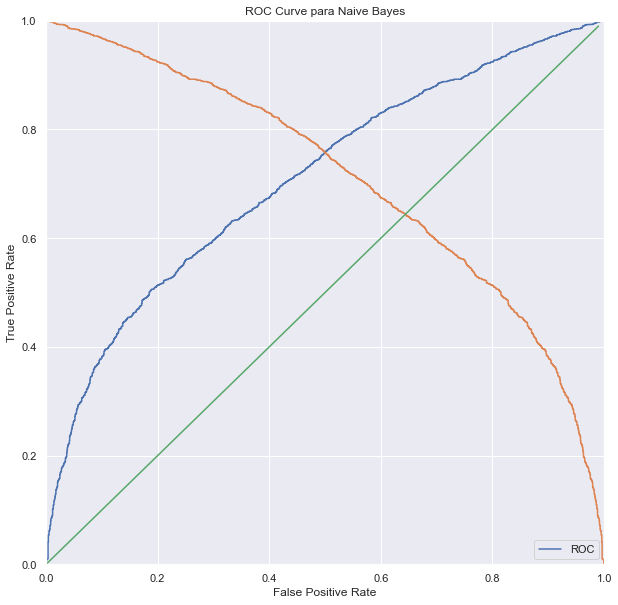

In [35]:
fig, ax = plt.subplots(figsize=(10,10))
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve para Naive Bayes')
plt.plot(fpr_nb, tpr_nb, label="ROC")
plt.plot(1-fpr_nb,tpr_nb)
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.legend()
plt.show()

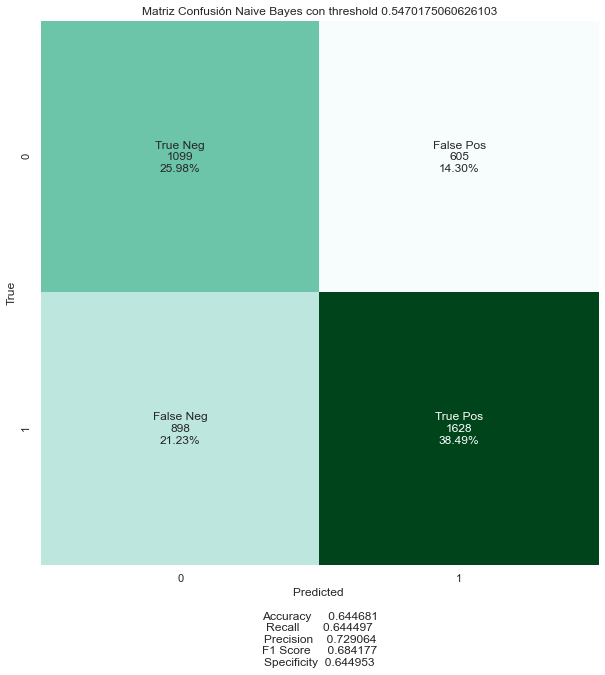

In [36]:
y_pred_nb_umbral = (y_preds_proba[2][:,1] > best_threshold_nb).astype(int)
heatmap_matrix_data(y_test, y_pred_nb_umbral, 'Matriz Confusión Naive Bayes con threshold '+str(best_threshold_logit1));

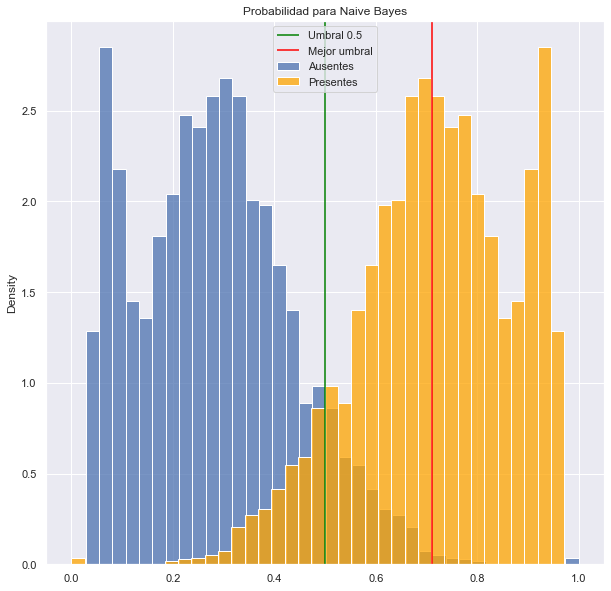

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
sns.histplot(data = y_preds_proba[2][:,0], stat = 'density', ax=ax, label="Ausentes")
sns.histplot(data = y_preds_proba[2][:,1], stat = 'density', color = 'orange', ax=ax, label="Presentes")
ylim = plt.ylim()
plt.vlines(0.5, ylim[0], ylim[1], color="green", label="Umbral 0.5")
plt.vlines(best_threshold_nb, ylim[0], ylim[1], color="red", label="Mejor umbral")
plt.ylim(ylim)
plt.title('Probabilidad para Naive Bayes')
plt.legend()
plt.show()

#### Análisis para Logística sin normalización

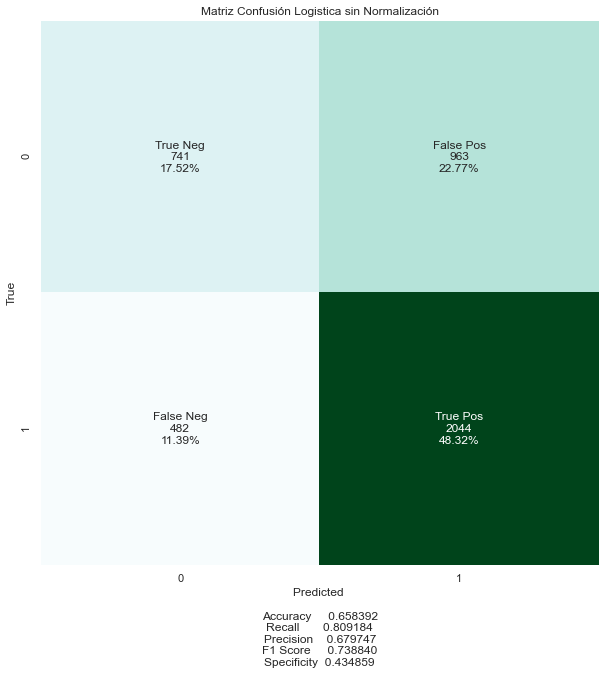

In [38]:
heatmap_matrix_data(y_test, y_preds[3], 'Matriz Confusión Logistica sin Normalización');

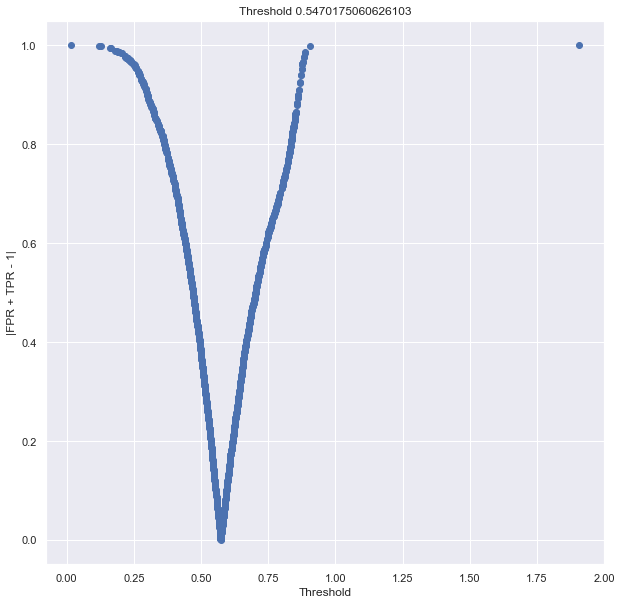

In [39]:
fpr_logit2,tpr_logit2,thr_logit2 = roc_curve(y_test, y_preds_proba[3][:,1])
best_threshold_logit2 = thr_logit2[np.argmin(np.abs(fpr_logit2+tpr_logit2-1))]

fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(thr_logit2,np.abs(fpr_logit2+tpr_logit2-1))
plt.xlabel("Threshold")
plt.ylabel("|FPR + TPR - 1|")
plt.title("Threshold "+str(best_threshold_logit1))
plt.show()

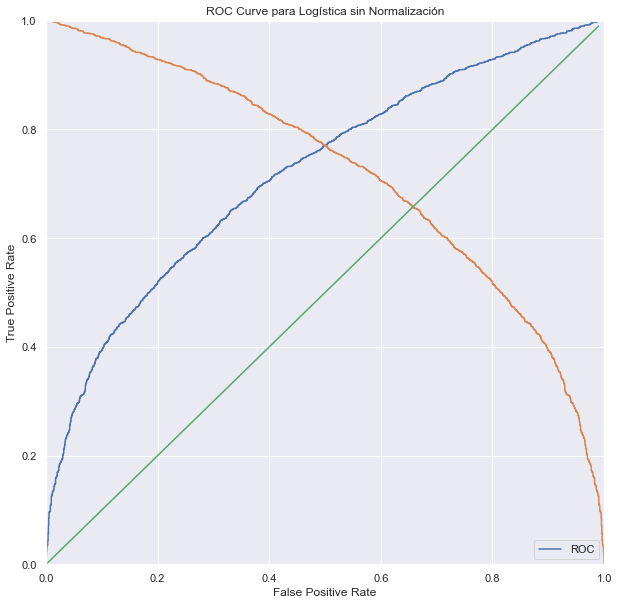

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve para Logística sin Normalización')
plt.plot(fpr_logit2, tpr_logit2, label="ROC")
plt.plot(1-fpr_logit2,tpr_logit2)
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.legend()
plt.show()

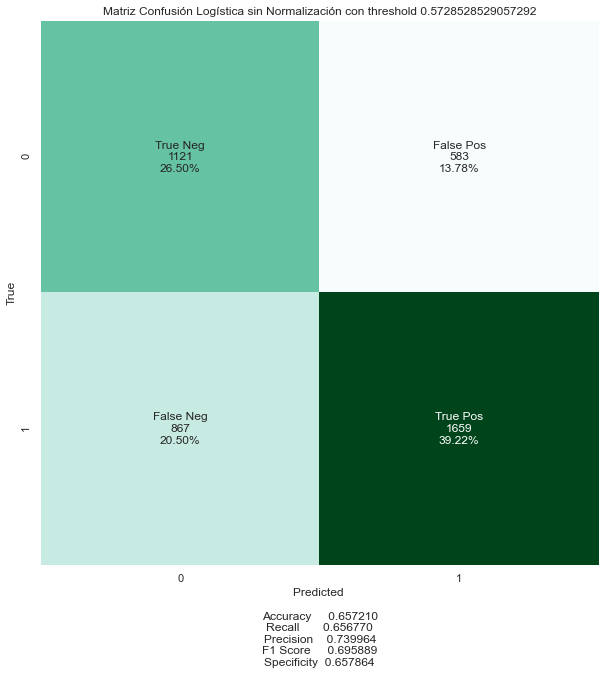

In [41]:
y_pred_logit2_umbral = (y_preds_proba[3][:,1] > best_threshold_logit2).astype(int)
heatmap_matrix_data(y_test, y_pred_logit2_umbral, 'Matriz Confusión Logística sin Normalización con threshold '+str(best_threshold_logit2));

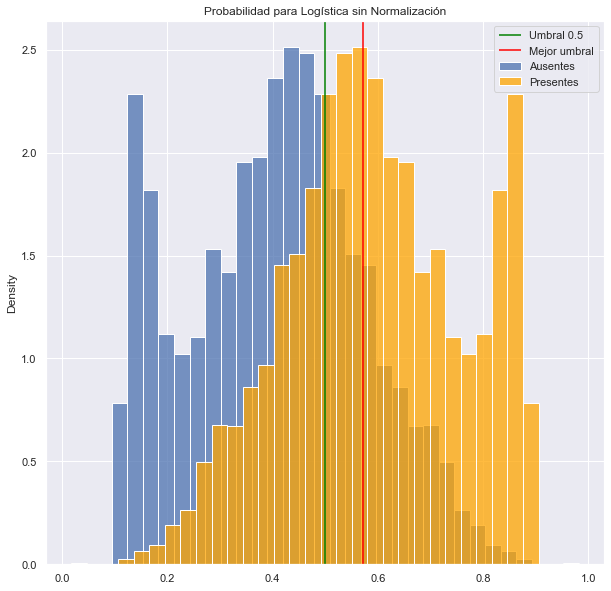

In [42]:
fig, ax = plt.subplots(figsize=(10,10))
sns.histplot(data = y_preds_proba[3][:,0], stat = 'density', ax=ax, label="Ausentes")
sns.histplot(data = y_preds_proba[3][:,1], stat = 'density', color = 'orange', ax=ax, label="Presentes")
ylim = plt.ylim()
plt.vlines(0.5, ylim[0], ylim[1], color="green", label="Umbral 0.5")
plt.vlines(best_threshold_logit2, ylim[0], ylim[1], color="red", label="Mejor umbral")
plt.ylim(ylim)
plt.title('Probabilidad para Logística sin Normalización')
plt.legend()
plt.show()

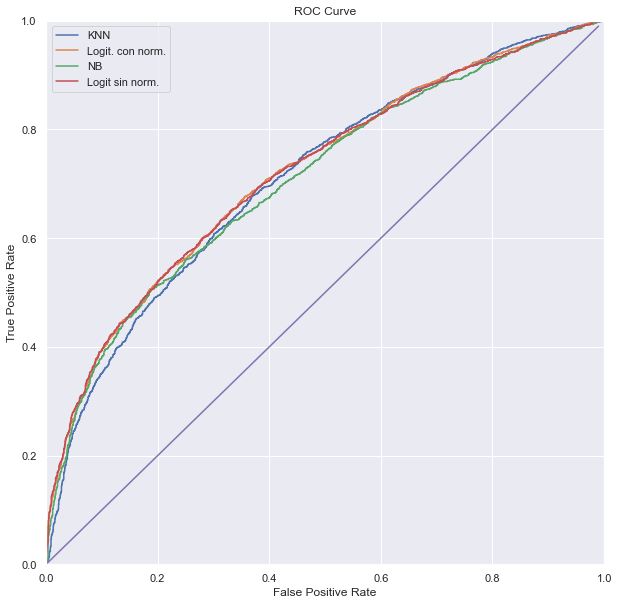

In [43]:
fig, ax = plt.subplots(figsize=(10,10))
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.plot(fpr_knn,tpr_knn)
plt.plot(fpr_logit1,tpr_logit1)
plt.plot(fpr_nb,tpr_nb)
plt.plot(fpr_logit2,tpr_logit2)
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.legend(['KNN','Logit. con norm.','NB','Logit sin norm.'])
plt.show()

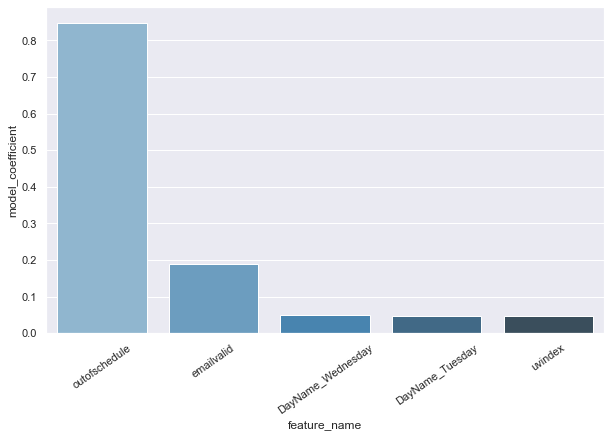

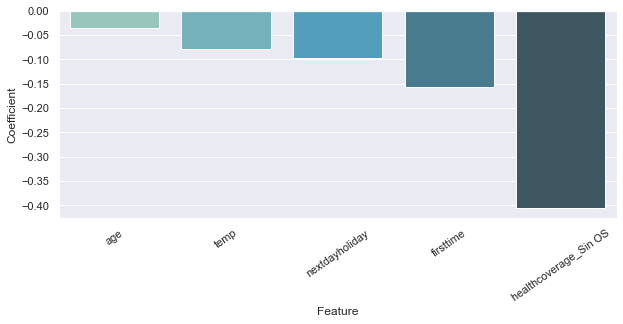

In [45]:
logReg_coeff = pd.DataFrame({'feature_name': X_test.columns, 'model_coefficient': grids[3].best_estimator_.coef_.transpose().flatten()})
logReg_coeff = logReg_coeff.sort_values('model_coefficient',ascending=False)
logReg_coeff_top = logReg_coeff.head(5)
logReg_coeff_bottom = logReg_coeff.tail(5)
# Plot top 5 coefficients
plt.figure().set_size_inches(10, 6)
fg3 = sns.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_top, palette="Blues_d")
fg3.set_xticklabels(rotation=35, labels=logReg_coeff_top.feature_name)
# Plot bottom 5 coefficients
plt.figure().set_size_inches(10,6)
fg4 = sns.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_bottom, palette="GnBu_d")
fg4.set_xticklabels(rotation=35, labels=logReg_coeff_bottom.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.subplots_adjust(bottom=0.4)